In [1]:
#Поддгрузка библоитек
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [283]:
#Функция для визуализации предсказания и скоринга по модели
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    plt.scatter(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [343]:
#Подгрузка датасет
df=pd.read_csv('train.csv')
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [344]:
#выделяем таргет в отдельный датафрейм 
y = df['Price']

In [383]:
#Функция бля предобраотки датасета
def prepoc(df):
    df['Rooms']=df['Rooms'].astype(str)
    df['Square']=df['Square'].astype(int)
    df['LifeSquare'].fillna(0,inplace=True)
    df['LifeSquare']=df['LifeSquare'].astype(int)
    df['KitchenSquare'].fillna(0,inplace=True)
    df['KitchenSquare'][df['KitchenSquare']==0]=(df['KitchenSquare'].mean())//1
    
    df['KitchenSquare']=df['KitchenSquare'].astype(int)
    df['HouseFloor'][df['HouseFloor']==0]=df['Floor'] #этаж в доме не может быть меньше, чем этаж квартиры
    df['HouseFloor']=df['HouseFloor'].astype(int)
    df['Ecology_1'].fillna(0,inplace=True)
    df['Ecology_1']=df['Ecology_1'].astype(int)
    
    df['Healthcare_1'].fillna(0,inplace=True)
    df['Healthcare_1']=df['Healthcare_1'].astype(int)

    try:
        df.drop(['Price','Ecology_2','Ecology_3','Shops_2'],axis=1,inplace=True)
    except:
        df.drop(['Ecology_2','Ecology_3','Shops_2'],axis=1,inplace=True)
        x = df
    return x


In [346]:
x=df.pipe(prepoc)
x.head()

C:\Users\Zviad.Sakhvadze\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null object
Square           10000 non-null int32
LifeSquare       10000 non-null int32
KitchenSquare    10000 non-null int32
Floor            10000 non-null int64
HouseFloor       10000 non-null int32
HouseYear        10000 non-null int64
Ecology_1        10000 non-null int32
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null int32
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
dtypes: int32(6), int64(9), object(1)
memory usage: 1015.7+ KB


C:\Users\Zviad.Sakhvadze\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [349]:
X_train,X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, shuffle = True, random_state = 42 )

In [373]:
model1=RandomForestRegressor(random_state=42)

In [374]:
param1={'n_estimators':[10,50,100,200], 'max_depth':range(1,8)}

In [375]:
%%time
gd1=GridSearchCV(model1, param1, scoring='r2',cv = KFold(n_splits=3,random_state = 42))
gd1.fit(x,y)

Wall time: 1min 1s


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=Non

In [376]:
gd1.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [377]:
gd1.best_score_

0.6742191026958073

In [378]:
model_best1 = GradientBoostingRegressor(n_estimators = 200,max_depth = 7,random_state=42)
model_best1.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.97
MAE:	11126.491
MSE:	256230605.025


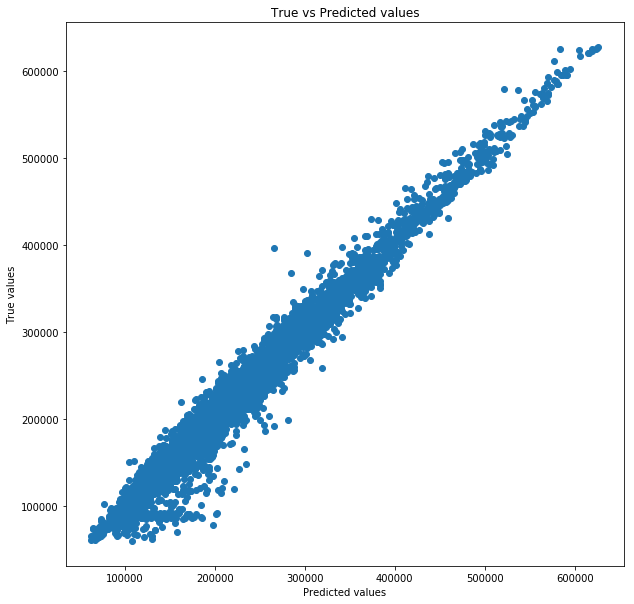

R2:	0.718
MAE:	28327.603
MSE:	2428742872.352


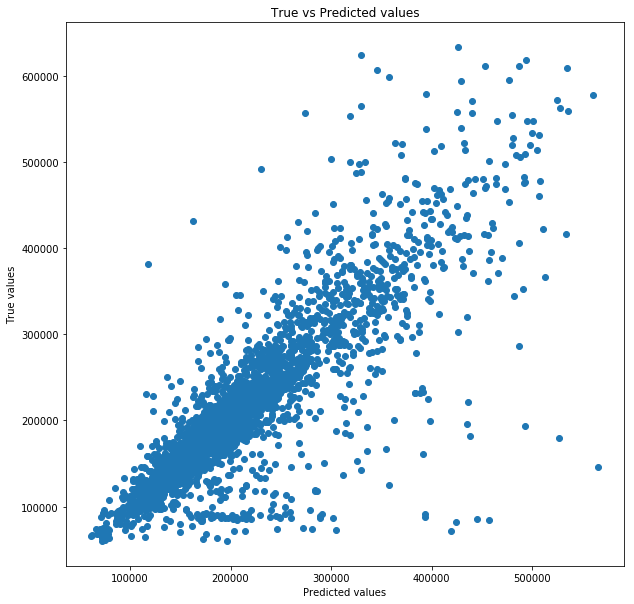

In [379]:
y_pred_=model_best1.predict(X_train)
evaluate_preds(y_train, y_pred_)


y_pred_t=model_best1.predict(X_test)
evaluate_preds(y_test, y_pred_t)

In [380]:
y_pred_t1=model_best1.predict(x_re)

In [381]:
df_re1=pd.DataFrame(y_pred_t,columns=['Price'])
df_fin1=pd.concat([df1['Id'],df_re],axis=1)

In [384]:
df_fin1.to_csv('ZSakhvadze_predictions.csv',index=False)
df_fin1.head()

,Id,Price
0,725,168826.756738
1,15856,206612.541960
2,5480,187273.152091
3,15664,374622.043919
4,14275,148588.146773
